# Load Sample Data for Verification

In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sunpy
from matplotlib import colors
from astropy.visualization import ImageNormalize, AsinhStretch

from dotenv import load_dotenv
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

## Raw Data Load

In [54]:
YEAR = 2019
RAW_DIR = os.path.join(DATA_DIR, "raw_data")

synoptic_drawings = os.listdir(os.path.join(RAW_DIR, f"{YEAR}_synoptic_drawings"))
sam_masks = os.listdir(os.path.join(RAW_DIR, f"{YEAR}_SAM_masks"))
chasm_selections = os.listdir(os.path.join(RAW_DIR, f"{YEAR}_CHASM_selections"))
sdo_fits = os.listdir(os.path.join(RAW_DIR, f"{YEAR}_SDO_FITS"))

date = f"{YEAR}-01-01"

In [55]:
def contains_date(filename, date):
    return date in filename

### SWPC Synoptic Map

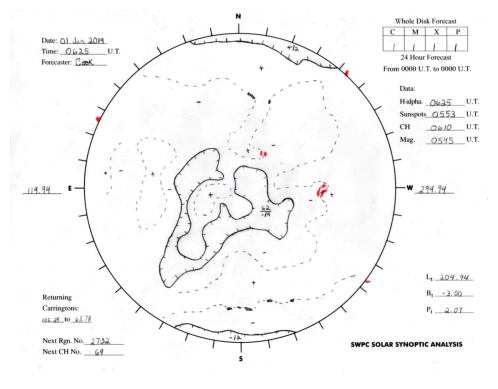

In [56]:
synoptic_map_path = os.path.join(RAW_DIR, f"{YEAR}_synoptic_drawings", [f for f in synoptic_drawings if contains_date(f, date)][0])

synoptic_map = plt.imread(synoptic_map_path)
plt.imshow(synoptic_map)
plt.axis('off')
plt.show()

### SAM Masks

The information stored in SAM masks follows this structure:

```
{
    'arr': {
        'segmentation': binary array,
        'area': area of the segmented region,
        'bbox': bounding box coordinates,
        'predicted_iou': predicted IoU,
        'point_coords': coordinates used to prompt SAM,
        'stability_score': stability score of the segmentation,
        'crop_box': coordinates of the crop box
    },
    ...
}
```

Masks found by SAM for 2019-01-01: 123
Filtered masks by area (10000 to 1000000): 43


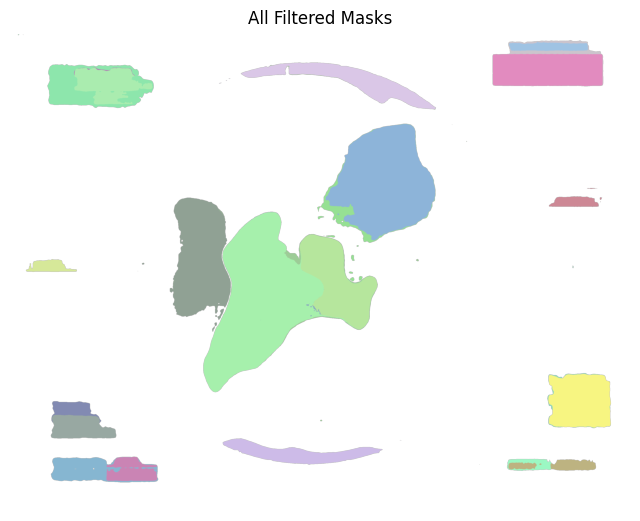

In [57]:
sam_mask_path = os.path.join(RAW_DIR, f"{YEAR}_SAM_masks", [f for f in sam_masks if contains_date(f, date)][0])
sam_mask = np.load(sam_mask_path, allow_pickle=True)

print(f"Masks found by SAM for {date}: {len(sam_mask.files)}")

# Filter the masks by area
min_area = 10000
max_area = 1000000
filtered_masks = []
for mask in sam_mask:
    mask_data = sam_mask[mask].item()
    area = mask_data['area']
    if min_area <= area <= max_area:
        filtered_masks.append(mask)

print(f"Filtered masks by area ({min_area} to {max_area}): {len(filtered_masks)}")

# Create a single composite image instead of multiple imshow calls
mask_shape = sam_mask[filtered_masks[0]].item()['segmentation'].shape
composite_image = np.zeros((mask_shape[0], mask_shape[1], 4))

for mask in filtered_masks:
    mask_data = sam_mask[mask].item()
    segmentation = mask_data['segmentation']
    random_color = np.random.rand(3)
    
    # Only update pixels that aren't already colored
    mask_indices = segmentation & (composite_image[:, :, 3] == 0)
    composite_image[mask_indices, :3] = random_color
    composite_image[mask_indices, 3] = 0.5

plt.figure(figsize=(8, 8))
plt.imshow(composite_image)
plt.title("All Filtered Masks")
plt.axis('off')
plt.show()

### CHASM Selections

The information stored in CHASM selections follows this structure:

```
{
  "info": [
    {
      "mask_region": {
        "segmentation": the binary segmentation map of the CH,
        "area": the area of the CH in pixels,
        "bbox": [x1, y1, x2, y2] of the bounding box of the CH,
        "predicted_iou": the predicted IOU of the mask by SAM,
        "point_coords": coordinates of the point used by SAM to predict the mask,
        "stability_score": SAM's assigned stability score for the mask,
        "crop_box": [x1, y1, x2, y2] of the cropped region of the CH
      },
      "id": CH ID from the drawing,
      "confidence": CH Confidence value 1-4 from the drawing,
      "polarity": CH Polarity +/- from the drawing,
      "flagged": True for bad mask, False for good mask
    },
    ...
  ]
}
```

Selections found by CHASM for 2019-01-01: 1


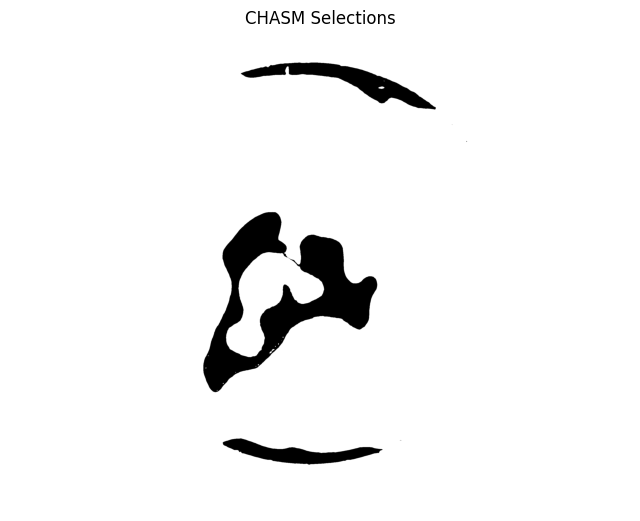

In [58]:
chasm_selection_path = os.path.join(RAW_DIR, f"{YEAR}_CHASM_selections", [f for f in chasm_selections if contains_date(f, date)][0])
chasm_selection = np.load(chasm_selection_path, allow_pickle=True)

print(f"Selections found by CHASM for {date}: {len(chasm_selection)}")

selected_chs = np.zeros((mask_shape[0], mask_shape[1], 4))
for item in chasm_selection['info']:
    segmentation = item['mask_region']['segmentation']
    mask_indices = segmentation & (selected_chs[:, :, 3] == 0)
    selected_chs[mask_indices, :3] = (0, 0, 0)
    selected_chs[mask_indices, 3] = 1
plt.figure(figsize=(8, 8))
plt.imshow(selected_chs)
plt.title("CHASM Selections")
plt.axis('off')
plt.show()

### SDO FITS Files

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


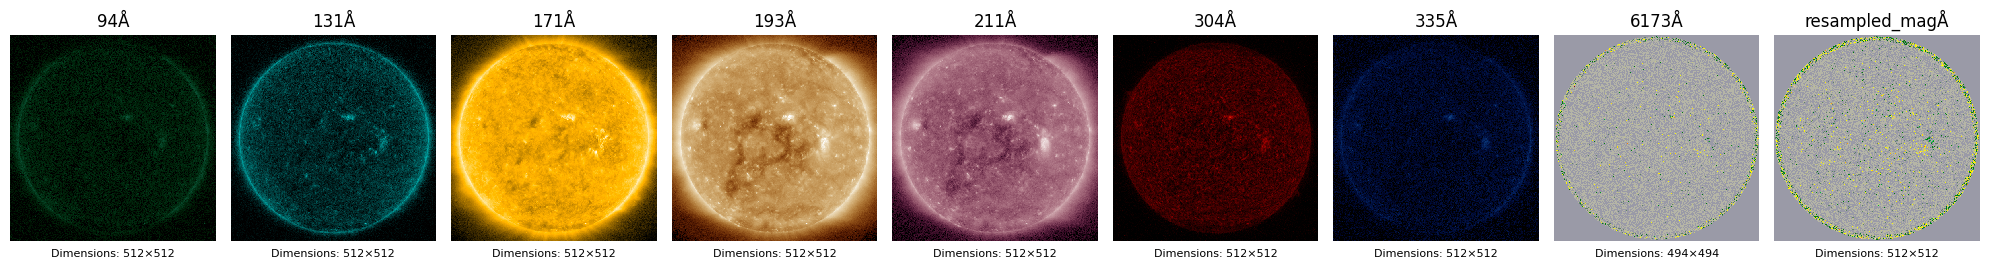

In [59]:
wavelengths = [w for w in sdo_fits if os.path.isdir(os.path.join(RAW_DIR, f"{YEAR}_SDO_FITS", w))]
wavelengths = sorted(wavelengths, key=lambda x: float(x) if x.isdigit() else float('inf'))
if 'resampled_mag' in wavelengths:
    wavelengths.remove('resampled_mag')
    wavelengths.append('resampled_mag')

fig = plt.figure(figsize=(20, 5))

for i, wavelength in enumerate(wavelengths):
    if not os.path.isdir(os.path.join(RAW_DIR, f"{YEAR}_SDO_FITS", wavelength)):
        continue
    
    # Find the FITS file for the current date
    fits_files = os.listdir(os.path.join(RAW_DIR, f"{YEAR}_SDO_FITS", wavelength))
    fits_file = [f for f in fits_files if contains_date(f, date[:10])][0]
    fits_path = os.path.join(RAW_DIR, f"{YEAR}_SDO_FITS", wavelength, fits_file)
    
    try:
        # Load the FITS file with sunpy
        smap = sunpy.map.Map(fits_path)
        
        # Create a subplot with WCS projection
        ax = fig.add_subplot(1, len(wavelengths), i+1, projection=smap.wcs)
        
        # Choose appropriate normalization based on wavelength
        if wavelength not in ['6173', 'resampled_mag']:
            norm = ImageNormalize(vmin=0, vmax=1500, stretch=AsinhStretch(.005))
        else:
            # For HMI data, use diverging colormap with symmetric limits
            vmax = max(abs(smap.min()), abs(smap.max()))
            norm = colors.Normalize(vmin=-vmax, vmax=vmax)
        
        # Plot the map
        smap.plot(axes=ax, norm=norm, cmap = 'hmimag' if wavelength in ['6173', 'resampled_mag'] else f'sdoaia{wavelength}')
        
        # Configure the axes
        ax.set_title(f"{wavelength}Å")
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.axis('off')
        
        # Add image dimensions info at the bottom
        ax.text(0.5, -0.08, f"Dimensions: {smap.data.shape[0]}×{smap.data.shape[1]}",
            transform=ax.transAxes, ha='center', fontsize=8)
        
    except Exception as e:
        ax = fig.add_subplot(1, len(wavelengths), i+1)
        ax.text(0.5, 0.5, f"Error loading {wavelength}\n{str(e)[:50]}", 
                ha='center', va='center')
        ax.set_title(wavelength)
        ax.axis('off')

plt.tight_layout()
plt.show()

## Prepared Data Load

Important note that the prepared data must be flipped vertically to display it appropriately. FITS does this automatically.

In [60]:
PREPARED_DIR = os.path.join(DATA_DIR, "prepared_data")

map_data = os.listdir(os.path.join(PREPARED_DIR, "map"))
mask_data = os.listdir(os.path.join(PREPARED_DIR, "mask"))

SIZE = "512"

Map data shape: (512, 512, 8)
Mask data shape: (512, 512, 1)


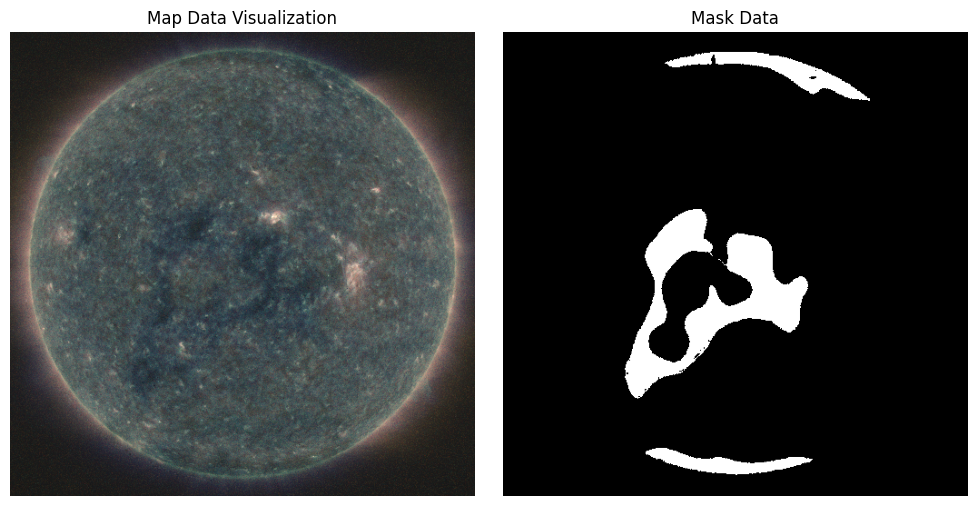

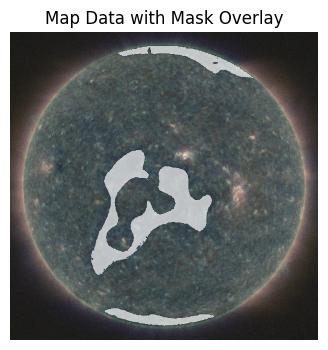

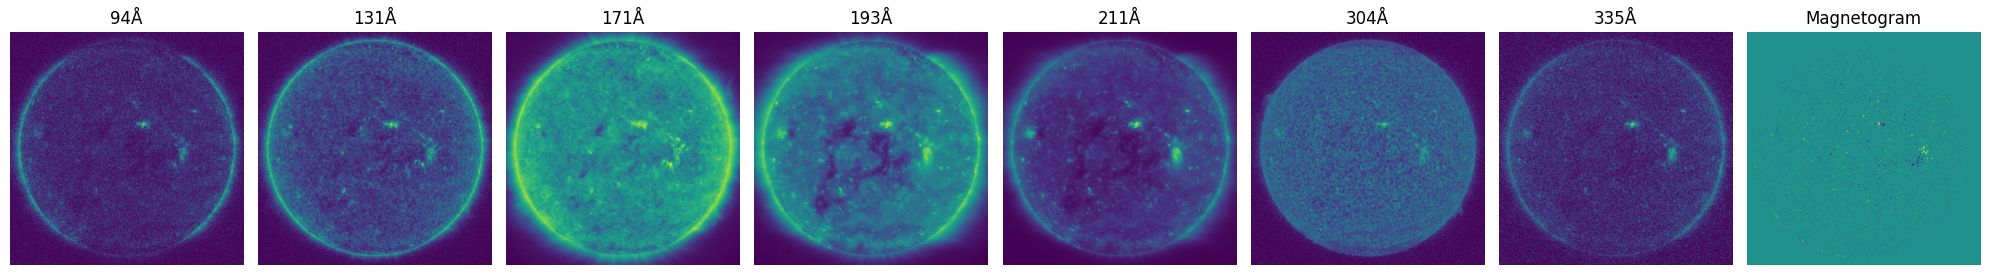

In [61]:
map_data_np = np.load(os.path.join(PREPARED_DIR, "map", SIZE, f"{date}.npy"), allow_pickle=True)
mask_data_np = np.load(os.path.join(PREPARED_DIR, "mask", SIZE, f"{date}.npy"), allow_pickle=True)

# Examine the shape of the data
print(f"Map data shape: {map_data_np.shape}")
print(f"Mask data shape: {mask_data_np.shape}")

# Flip the data vertically
map_data_np = np.flipud(map_data_np)
mask_data_np = np.flipud(mask_data_np)


plt.figure(figsize=(10, 5))


rgb_image = np.zeros((map_data_np.shape[0], map_data_np.shape[1], 3))

# Define colors for each channel (RGB values)
colors = [
    [1.0, 0.0, 0.0],  # Red - 94Å
    [0.0, 1.0, 0.0],  # Green - 131Å
    [0.0, 0.0, 1.0],  # Blue - 171Å
    [1.0, 1.0, 0.0],  # Yellow - 193Å
    [1.0, 0.0, 1.0],  # Magenta - 211Å
    [0.0, 1.0, 1.0],  # Cyan - 304Å
    [1.0, 0.5, 0.0],  # Orange - 335Å
    [0.7, 0.7, 0.7],  # Gray - Magnetogram
]

# Normalize and add each channel with a unique color
for i in range(map_data_np.shape[2]):
    # Normalize data for better visualization
    channel_data = map_data_np[:, :, i]
    normalized = (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data) + 1e-8)
    
    # Add the colored channel to the RGB image
    for c in range(3):  # RGB components
        rgb_image[:, :, c] += normalized * colors[i][c] * 0.25  # Scale factor to avoid saturation

# Clip values to [0, 1] range
rgb_image = np.clip(rgb_image, 0, 1)

# Display the composite image
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title("Map Data Visualization")
plt.axis('off')

# Display the mask data
plt.subplot(1, 2, 2)
plt.imshow(mask_data_np[:, :, 0], cmap='gray')
plt.title("Mask Data")
plt.axis('off')

plt.tight_layout()
plt.show()

# Display a version with mask overlaid on the map
plt.figure(figsize=(4, 4))
plt.imshow(rgb_image)
# Overlay mask with semi-transparency if mask has any non-zero values
if np.any(mask_data_np):
    mask_overlay = np.zeros((mask_data_np.shape[0], mask_data_np.shape[1], 4))
    mask_overlay[mask_data_np[:, :, 0] > 0, :] = [1, 1, 1, 0.7]  # White with 70% opacity
    plt.imshow(mask_overlay)
plt.title("Map Data with Mask Overlay")
plt.axis('off')
plt.show()


num_channels = map_data_np.shape[2]
fig, axes = plt.subplots(1, num_channels, figsize=(20, 4))
channel_names = [
    "94Å",
    "131Å",
    "171Å",
    "193Å", 
    "211Å",
    "304Å",
    "335Å",
    "Magnetogram"
]

for i in range(num_channels):
    channel_data = map_data_np[:, :, i]
    normalized = (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data) + 1e-8)
    axes[i].imshow(normalized, cmap='viridis')
    
    # Set the title with the wavelength if available
    if i < len(channel_names):
        axes[i].set_title(channel_names[i])
    else:
        axes[i].set_title(f"Channel {i+1}")
    
    axes[i].axis('off')

plt.tight_layout()
plt.show()